The Setup and Finding the Match

In [18]:
import asyncio
import aiohttp
import nest_asyncio
import pandas as pd
from understat import Understat

nest_asyncio.apply()

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}


async def get_team_matches(team_name, season):
    async with aiohttp.ClientSession(headers=HEADERS) as session:
        understat = Understat(session)
        print(f"Searching for {team_name} matches in {season}...")

        try:
            results = await understat.get_team_results(team_name, season)
            return results
        except Exception as e:
            print(f"Error connecting: {e}")
            return []


target_team = input("Enter Team Name (e.g., Liverpool, Arsenal): ")
target_season = int(input("Enter Season Year (e.g., 2024): "))

matches_data = asyncio.run(get_team_matches(target_team, target_season))


df_matches = pd.DataFrame(matches_data)

df_matches = df_matches[df_matches["goals"].apply(lambda x: x is not None)]

df_matches["opponent"] = df_matches.apply(
        lambda row: row["a"]["title"] if row["side"] == "h" else row["h"]["title"],
        axis=1,
    )

df_matches["result"] = df_matches.apply(
        lambda row: str(row["goals"]["h"]) + " - " + str(row["goals"]["a"]), axis=1
    )

print(f"\n--- MATCH LIST FOR {target_team.upper()} ---")
display_cols = ["id", "datetime", "opponent", "result", "side"]
print(df_matches[display_cols].tail(10).to_string(index=False))

Searching for Liverpool matches in 2024...

--- MATCH LIST FOR LIVERPOOL ---
   id            datetime       opponent result side
26876 2025-03-08 15:00:00    Southampton  3 - 1    h
26901 2025-04-02 20:00:00        Everton  1 - 0    h
26906 2025-04-06 13:00:00         Fulham  3 - 2    a
26916 2025-04-13 13:00:00       West Ham  2 - 1    h
26928 2025-04-20 15:30:00      Leicester  0 - 1    a
26936 2025-04-27 15:30:00      Tottenham  5 - 1    h
26948 2025-05-04 15:30:00        Chelsea  3 - 1    a
26952 2025-05-11 15:30:00        Arsenal  2 - 2    h
26965 2025-05-19 19:00:00       Brighton  3 - 2    a
26975 2025-05-25 15:00:00 Crystal Palace  1 - 1    h


Getting the Shot Data

In [15]:
match_id = input("Paste the Match ID here: ")
async def get_shot_info(match_id):
    async with aiohttp.ClientSession() as session:
        understat=Understat(session)
        
        shots= await understat.get_match_shots(match_id)
        return shots
    
shot_data=asyncio.run(get_shot_info(match_id))

df_home=pd.DataFrame(shot_data["h"])
df_away=pd.DataFrame(shot_data["a"])

def clean_df(df):
    cols=["X", "Y", "xG", "minute"]
    for col in cols:
        df[col]=pd.to_numeric(df[col])
    return df

df_home=clean_df(df_home)
df_away=clean_df(df_away)

home_team_name=df_home["h_team"].iloc[0]
away_team_name=df_away["a_team"].iloc[0]

if home_team_name == target_team:
    my_team_df = df_home
    opp_df = df_away
    opp_name = away_team_name
    my_side = "Home"
else:
    my_team_df = df_away
    opp_df = df_home
    opp_name = home_team_name
    my_side = "Away"

print(f"Data Loaded: {target_team} ({my_side}) vs {opp_name}")   
print(f"Data Loaded \n Home Shots: {len(df_home)} | Away Shots: {len(df_away)}")
df_home.head(3)



Data Loaded: Liverpool (Home) vs Arsenal
Data Loaded 
 Home Shots: 14 | Away Shots: 15


,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,633600,7,SavedShot,0.917,0.460,0.472571,Luis Díaz,h,10408,OpenPlay,2024,RightFoot,26952,Liverpool,Arsenal,2,2,2025-05-11 15:30:00,Mohamed Salah,Pass
1,633602,18,MissedShots,0.899,0.577,0.088672,Cody Gakpo,h,11296,OpenPlay,2024,RightFoot,26952,Liverpool,Arsenal,2,2,2025-05-11 15:30:00,Andrew Robertson,Pass
2,633603,19,Goal,0.952,0.551,0.488618,Cody Gakpo,h,11296,OpenPlay,2024,Head,26952,Liverpool,Arsenal,2,2,2025-05-11 15:30:00,Andrew Robertson,Cross


The Visulaisation of the Data

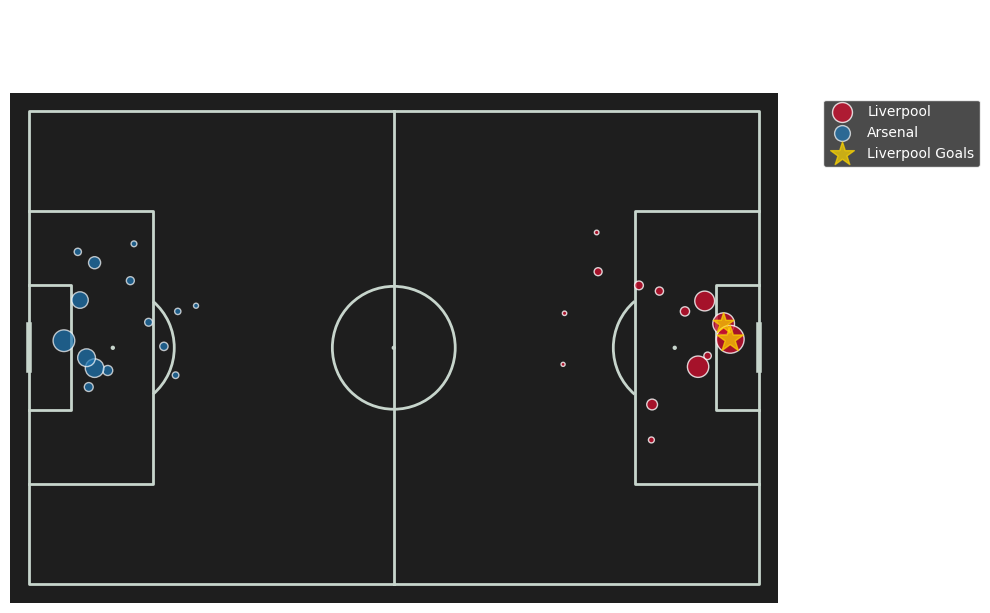

In [17]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch

    
    
pitch=Pitch(pitch_type="opta", pitch_color="#1e1e1e", line_color="#c7d5cc")
fig, ax=pitch.draw(figsize=(10, 8))

pitch.scatter(my_team_df["X"]*100, my_team_df["Y"]*100, ax=ax, s=my_team_df["xG"]*500, color="#C8102E", edgecolor="white", alpha=0.8, label=target_team)

pitch.scatter((100-(opp_df["X"]*100)),(100-(opp_df["Y"]*100)) , ax=ax, alpha=0.7, s=opp_df["xG"]*500, color="#1f77b4", edgecolor="white", label=opp_name)

my_team_goals=my_team_df[my_team_df["result"]=="Goal"]
pitch.scatter(my_team_goals["X"]*100, my_team_goals["Y"]*100, ax=ax, color="gold", marker="*", s=my_team_goals["xG"]*500, alpha=0.7, label=(target_team+" Goals"))

ax.set_title(f"Liverpool vs {opp_name} | Shot Map \n Bigger Circle = Higher xG", fontsize=20, color="white", pad=20)
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), facecolor="#1e1e1e", labelcolor="white", edgecolor="white")

plt.draw()